In [87]:
import scipy.io.wavfile
import numpy as np 
import sys
import os
import glob
import librosa
from librosa.feature import mfcc

# Given a wavfile, computes mfcc and saves mfcc data
def create_ceps(wavfile):
	song_array, sampling_rate = librosa.load(wavfile)
# 	print(sampling_rate)
# 	print(song_array)
# 	song_array = song_array.astype(float)
# 	print(song_array)
	"""Get MFCC
	ceps  : ndarray of MFCC
	mspec : ndarray of log-spectrum in the mel-domain
	spec  : spectrum magnitude
	"""
	ceps=mfcc(song_array)
	#ceps, mspec, spec= mfcc(song_array)
# 	print(ceps.shape)
	#this is done in order to replace NaN and infinite value in array
	bad_indices = np.where(np.isnan(ceps))
	b=np.where(np.isinf(ceps))
	ceps[bad_indices]=0
	ceps[b]=0
	write_ceps(ceps, wavfile)

# Saves mfcc data 
def write_ceps(ceps, wavfile):
	base_wav, ext = os.path.splitext(wavfile)
	data_wav = base_wav + ".ceps"
	np.save(data_wav, ceps)


In [119]:
GENRE_LIST = [ "blues","classical","country","disco","metal", "hiphop", "jazz", "pop", "reggae", "rock"]
# GENRE_DIR = "/home/dhruvesh/Desktop/dsp-final/genres"
GENRE_DIR = "Data\\genres_original"


for label, genre in enumerate(GENRE_LIST):
	for fn in glob.glob(os.path.join(GENRE_DIR, genre)):
		for wavfile in os.listdir(fn):
			if wavfile.endswith("wav"):
				create_ceps(os.path.join(GENRE_DIR, genre,wavfile))

# Funkcje potrzebne do uczenia 


In [1]:
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import scipy
import os
import sys
import glob
import numpy as np
import joblib
from random import shuffle
import json


"""reads FFT-files and prepares X_train and y_train.
genre_list must consist of names of folders/genres consisting of the required FFT-files
base_dir must contain genre_list of directories
"""
def read_fft(genre_list, base_dir):
	X = []
	y = []
	for label, genre in enumerate(genre_list):
		# create UNIX pathnames to id FFT-files.
		genre_dir = os.path.join(base_dir, genre, "*.fft.npy")
		# get path names that math genre-dir
		file_list = glob.glob(genre_dir)
		for file in file_list:
			fft_features = np.load(file)
			X.append(fft_features)
			y.append(label)
	
	return np.array(X), np.array(y)


"""reads MFCC-files and prepares X_train and y_train.
genre_list must consist of names of folders/genres consisting of the required MFCC-files
base_dir must contain genre_list of directories
"""
def read_ceps(genre_list, base_dir):
	WAV_SIZE = 1293
	X = []
	y = []
	for label, genre in enumerate(genre_list):
		for fn in glob.glob(os.path.join(base_dir, genre, "*.ceps.npy")):
			ceps = np.load(fn)
			num_ceps = len(ceps)
			data = np.mean(ceps[int(num_ceps*1/10):int(num_ceps*9/10)], axis=0)
# 			print(data.shape)
			if(data.shape[0] == WAV_SIZE):
				X.append(data)
				y.append(label)
# 			X.append(ceps)

# 	print(np.array(X).shape)
# 	print(len(y))
	return np.array(X), np.array(y)

def learn_and_classify(X_train, y_train, X_test, y_test, genre_list):

	
# 	print(len(X_train))
# 	print(len(X_train[0]))
# 	print(np.array(X_train).shape)
# 	print(X_train)
	#Logistic Regression classifier

    #3d array need to reshape into a 2d
# 	nsamples_train, nx_train, ny_train = X_train.shape
# 	d2_X_train = X_train.reshape((nsamples_train,nx_train*ny_train))
    
# 	nsamples_test, nx_test, ny_test = X_test.shape
# 	d2_X_test = X_test.reshape((nsamples_test,nx_test*ny_test))


	logistic_classifier = linear_model.LogisticRegression()
	logistic_classifier.fit(X_train, y_train)
	logistic_predictions = logistic_classifier.predict(X_test)
	logistic_accuracy = accuracy_score(y_test, logistic_predictions)
	logistic_cm = confusion_matrix(y_test, logistic_predictions)
	print("logistic accuracy = " + str(logistic_accuracy))
	print("logistic_cm:")
	print(logistic_cm)

	#change the pickle file when using another classifier eg model_mfcc_fft

# 	joblib.dump(logistic_classifier, 'saved_models/model_mfcc_log.pkl')

	#K-Nearest neighbour classifier

	knn_classifier = KNeighborsClassifier()
	knn_classifier.fit(X_train, y_train)
	knn_predictions = knn_classifier.predict(X_test)
	knn_accuracy = accuracy_score(y_test, knn_predictions)
	knn_cm = confusion_matrix(y_test, knn_predictions)
	print("knn accuracy = " + str(knn_accuracy))
	print("knn_cm:") 
	print(knn_cm)
# 	joblib.dump(knn_classifier, 'saved_models/model_mfcc_knn.pkl')
	
# 	plot_confusion_matrix(logistic_cm, "Confusion matrix", genre_list)
	plot_confusion_matrix(knn_cm, "Confusion matrix for KNN classification", genre_list)


def plot_confusion_matrix(cm, title, genre_list, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(genre_list))
    plt.xticks(tick_marks, genre_list, rotation=45)
    plt.yticks(tick_marks, genre_list)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [2]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    print(X.shape)
    print(X)
    
    return  X, y

new1 (756, 1293)
******USING MFCC******


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic accuracy = 0.21693121693121692
logistic_cm:
[[6 4 3 0 0 1 2 2 0 3]
 [3 5 0 1 1 0 3 4 1 3]
 [3 3 0 1 5 1 1 1 2 2]
 [2 3 0 1 0 1 1 1 2 1]
 [4 1 2 2 6 1 1 2 1 2]
 [2 0 1 1 6 4 0 0 3 0]
 [2 0 1 0 0 0 5 3 2 3]
 [0 0 0 2 1 4 1 8 2 0]
 [3 0 2 1 1 3 2 2 5 2]
 [2 2 1 4 4 0 1 4 3 1]]
knn accuracy = 0.18518518518518517
knn_cm:
[[ 1  6  0  0 13  0  0  0  0  1]
 [ 0 13  0  0  7  0  0  0  0  1]
 [ 0  8  0  0 10  0  1  0  0  0]
 [ 0  3  0  0  9  0  0  0  0  0]
 [ 1  4  1  0 16  0  0  0  0  0]
 [ 3  0  0  0 12  0  0  0  0  2]
 [ 0  6  0  0  9  0  1  0  0  0]
 [ 1  3  0  0 12  0  1  1  0  0]
 [ 1  6  0  0 10  0  0  0  1  3]
 [ 1  7  0  0 12  0  0  0  0  2]]


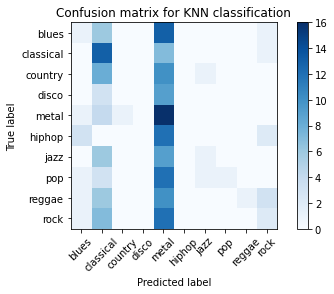

*********************


In [3]:
# DATA_PATH = "Data\\data3.json"

# base_dir_fft  = GENRE_DIR
# base_dir_mfcc = GENRE_DIR

"""list of genres (these must be folder names consisting .wav of respective genre in the base_dir)
Change list if needed.
"""
GENRE_LIST = [ "blues","classical","country","disco","metal", "hiphop", "jazz", "pop", "reggae", "rock"]
GENRE_DIR = "Data\\genres_original"

#genre_list = ["classical", "jazz"] IF YOU WANT TO CLASSIFY ONLY CLASSICAL AND JAZZ

#use FFT
# X, y = read_fft(genre_list, base_dir_fft)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)
# print('\n******USING FFT******')
# learn_and_classify(X_train, y_train, X_test, y_test, genre_list)
# print('*********************\n')

#use MFCC
X,y = read_ceps(GENRE_LIST, GENRE_DIR)
# print(np.array(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)
print("new1",X_train.shape)
print('******USING MFCC******')
learn_and_classify(X_train, y_train, X_test, y_test, GENRE_LIST)
print('*********************')